In [ ]:
steamimport numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import scipy

from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

#for testing
import time

#stuff to make it quicker
!sudo apt-get install pigz

# Downloader

In [ ]:
# Restart runtime until it has a good download speed >10MB/s
t0 = time.time()
!wget #FILL, you can download your data from wherever you've uploaded it
t1 = time.time()
print("Download took {0} seconds".format(t1-t0))
st = time.time()
!pigz -d DataReduced.tar.gz
!tar -xf DataReduced.tar
et = time.time()
print("Decompress took {0} seconds".format(et-st))
print("Total time: {0} seconds".format((et-st)+(t1-t0)))
!ls

--2022-12-09 15:40:50--  https://alidataschoolwork.s3.us-west-1.amazonaws.com/DataReduced.tar.gz
Resolving alidataschoolwork.s3.us-west-1.amazonaws.com (alidataschoolwork.s3.us-west-1.amazonaws.com)... 3.5.161.152
Connecting to alidataschoolwork.s3.us-west-1.amazonaws.com (alidataschoolwork.s3.us-west-1.amazonaws.com)|3.5.161.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16038349299 (15G) [application/x-gzip]
Saving to: ‘DataReduced.tar.gz’

DataReduced.tar.gz  100%[===================>]  14.94G  10.2MB/s    in 14m 32s 

2022-12-09 15:55:22 (17.5 MB/s) - ‘DataReduced.tar.gz’ saved [16038349299/16038349299]

Download took 872.5361337661743 seconds
Decompress took 231.52379703521729 seconds
Total time: 1104.0599308013916 seconds
DataReduced  DataReduced.tar  gdrive  sample_data


# DataLoader

In [ ]:
#Labels
cats = ["Food",
"Home Appliances",
"Computer & Office",
"Home Improvement",
"Home & Garden",
"Sports & Entertainment",
"Education & Office Supplies",
"Toys & Hobbies",
"Security & Protection",
"Automobiles & Motorcycles",
"Lights & Lighting",
"Consumer Electronics",
"Beauty & Health",
"Shoes",
"Electronic Components & Supplies",
"Cellphones & Telecommunications",
"Tools",
"Mother & Kids",
"Furniture",
"Jewelry & Accessories",
"Watches",
"Luggage & Bags",
"Hair Extensions & Wigs",
"Novelty & Special Use",
"Weddings & Events",
"Women's Clothing",
"Men's Clothing",
"Apparel Accessories",
"Underwear & Sleepwears"]

In [ ]:
print(cats[4])
print(cats[9])

Home & Garden
Automobiles & Motorcycles


# Ny sektion

In [ ]:
#Replace with the final model
from keras.applications.resnet_v2 import preprocess_input
batch_size = 320
df=pd.read_csv(r"FILL")
datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.3)
#Divides dataset into a training_data set and a validation_data set
train_data = datagen.flow_from_dataframe(dataframe=df, directory=r"FILL",
x_col="img",
y_col=cats,
class_mode="raw",
target_size=(224,224),
batch_size=batch_size,
shuffle=True,
subset="training")

val_data = datagen.flow_from_dataframe(dataframe=df, directory=r"FILL",
x_col="img",
y_col=cats,
class_mode="raw",
target_size=(224,224),
batch_size=batch_size,
shuffle=False,
subset="validation")


Found 393237 validated image filenames.
Found 168529 validated image filenames.


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]


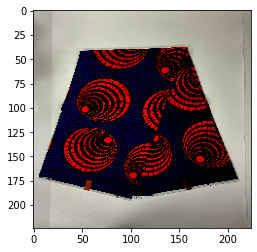

In [ ]:
#test the generator
imgs, labels = val_data.next()
print(labels[0])
plt.imshow(imgs[0])
plt.show()


# Model

## Init

In [ ]:
from tensorflow import keras
base_model = keras.Sequential(keras.applications.ResNet50V2(
  weights='imagenet',  # Load weights pre-trained on ImageNet.
  input_shape=(224, 224, 3),
  include_top=False, # Do not include the ImageNet classifier at the top.
  classifier_activation="sigmoid" # Apply desired activation function
))

base_model.trainable = False

inputs = keras.Input(shape=(224, 224, 3))


x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(2048, activation = "relu")(x)
#x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(2048, activation = "relu")(x)
outputs = keras.layers.Dense(29, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)
model.summary()
print(len(model.non_trainable_weights))
print(len(model.trainable_weights))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 2048)              4196352   
                                                                 
 dense_4 (Dense)             (None, 2048)              4196352   
                                                                 
 dense_5 (Dense)             (None, 29)                59421     
                                                           

In [ ]:
model.trainable = True

In [ ]:
model.summary()

In [ ]:
#Helper function to see trainability on layers
def get_trainability(model): # Takes Keras model and returns dictionary with layer names of Model as key, and its trainability as value/item
    train_dict = {}
    for layer in model.layers:
        if isinstance(layer, keras.models.Model):
            train_dict.update(get_trainability(layer))
        else:
            train_dict[layer.name] = layer.trainable
    return train_dict

get_trainability(model)

In [ ]:
model.load_weights('FILL') # Used to go back to previous weights
base_model.trainable = True

In [ ]:
model = keras.models.load_model('FILL') # Used to load a previous model to prevent overfitting

In [ ]:
#Load previous model
import tensorflow as tf
new_model = tf.keras.models.load_model('FILL')
new_model.summary()

In [ ]:
from tensorflow import keras
from keras import callbacks
!pip install -q pyyaml h5py
checkpoint_filepath = "FILL"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_weights_only = True,
    monitor = 'val_loss',
    save_best_only = False,
    verbose = 1,)

model_EarlyStopping = keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 3,
    mode = 'min',
)

model_logger = keras.callbacks.CSVLogger(
    filename = "3DenseDropLog2",
    separator = ",",
    append = True
)
callback_list = [model_checkpoint_callback, model_EarlyStopping, model_logger]

In [ ]:
#Compile the model and train
model.compile(optimizer=keras.optimizers.Adam(1e-7),
              loss=keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[keras.metrics.AUC()])

In [ ]:
print(len(model.non_trainable_weights))
print(len(model.trainable_weights))

98
178


In [ ]:
get_trainability(model)

In [ ]:
model.summary()

In [ ]:
model.load_weights("FILL")

In [ ]:
model.load_weights("FILL") 

In [ ]:
model.fit(train_data, validation_data=val_data, steps_per_epoch=64, epochs = 25, validation_steps=20, callbacks = callback_list)

Epoch 1/25
64/64 [==============================] - ETA: 0s - loss: 0.0895 - auc: 0.9208
Epoch 1: saving model to /content/gdrive/MyDrive/model/Checkpoint/Final_test_mod_checkpoint_01_0.082601.hdf5
64/64 [==============================] - 107s 2s/step - loss: 0.0895 - auc: 0.9208 - val_loss: 0.0826 - val_auc: 0.9375
Epoch 2/25
64/64 [==============================] - ETA: 0s - loss: 0.0876 - auc: 0.9232
Epoch 2: saving model to /content/gdrive/MyDrive/model/Checkpoint/Final_test_mod_checkpoint_02_0.083851.hdf5
64/64 [==============================] - 107s 2s/step - loss: 0.0876 - auc: 0.9232 - val_loss: 0.0839 - val_auc: 0.9351
Epoch 3/25
64/64 [==============================] - ETA: 0s - loss: 0.0882 - auc: 0.9234
Epoch 3: saving model to /content/gdrive/MyDrive/model/Checkpoint/Final_test_mod_checkpoint_03_0.083720.hdf5
64/64 [==============================] - 106s 2s/step - loss: 0.0882 - auc: 0.9234 - val_loss: 0.0837 - val_auc: 0.9360
Epoch 4/25
64/64 [============================

In [ ]:
#For training only the decoder of the model, remember to change
model.fit(train_data, validation_data=val_data, steps_per_epoch=128, epochs = 10, validation_steps=5, callbacks = callback_list)

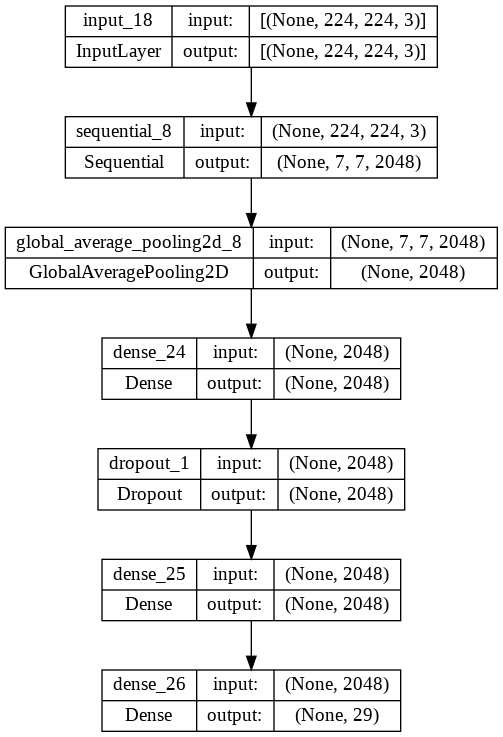

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
!mkdir -p saved_model
model.save('FILL')

1
(224, 224, 3)


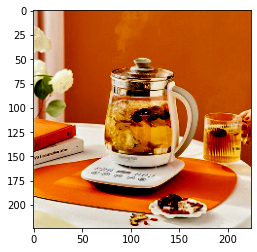

1/1 [==============================] - 0s 21ms/step
1


In [ ]:
imgs, labels = val_data.next()
print(np.argmax(labels[0]))
print(imgs[0].shape)
plt.imshow(imgs[0])
plt.show()
img = np.expand_dims(imgs[0], axis=0)
pred = model.predict(img)
print(np.argmax(pred))

In [ ]:
from tensorflow import math
import numpy as np
from sklearn.metrics import confusion_matrix

In [ ]:
model.load_weights('FILL')

In [ ]:
y_pred = model.predict(val_data)

527/527 [==============================] - 657s 1s/step


In [ ]:
print(np.argmax(val_data.labels))

0


In [ ]:
result = confusion_matrix([np.argmax(y) for y in val_data.labels], [np.argmax(y) for y in y_pred] , normalize='pred')
print(len(result))

29


In [ ]:
print(len(result[0]))

29


In [ ]:
np.savez("LModelPred2.npz",y_true=val_data.labels, y_pred=y_pred)

In [ ]:
for i in range(len(result)):
  if result[i][i] < 0.5:
    print(i,result[i][i])

1 0.427877947295423
3 0.40923441199684296
4 0.3592970275547841
5 0.4198904200564503
8 0.42907585535127235
9 0.30364806866952787
10 0.46325392802838317
11 0.3444277431823062
12 0.48344438749359303
16 0.4282863939835776
28 0.4531328320802005


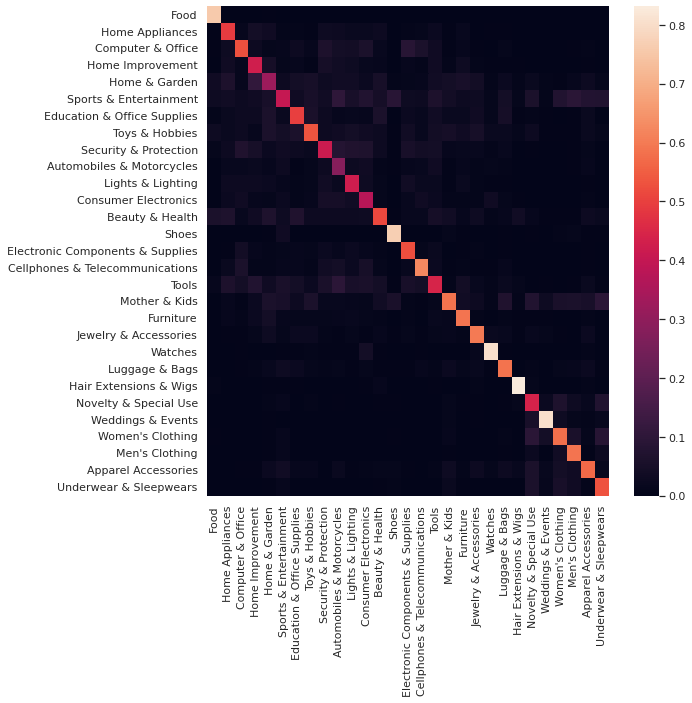

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(result, cats, cats)
plt.figure(figsize=(9,9))
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm, annot=False) # font size

plt.show()

In [ ]:
np.save("FILL", result)

In [ ]:
print(cats[22])

Hair Extensions & Wigs


In [ ]:
new_model = keras.models.load_model('FILL')

In [ ]:
new_model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss=keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[keras.metrics.AUC()])

In [ ]:
new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 29)                59421     
                                                                 
Total params: 23,624,221
Trainable params: 59,421
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
y_pred2 = new_model.predict(val_data)

527/527 [==============================] - 539s 1s/step


In [ ]:
result2 = confusion_matrix([np.argmax(y) for y in val_data.labels], [np.argmax(y) for y in y_pred2] , normalize='pred')
print(len(result2))

29


In [ ]:
df_cm = pd.DataFrame(result2, cats, cats)
plt.figure(figsize=(9,9))
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm, annot=False) # font size

plt.show()